Files already downloaded and verified
Files already downloaded and verified
Epoch 1 ends here, and the validation begins
One more minimaa
epoch : 1
training loss: 1857.9199
validation loss: 312.4508
Epoch 2 ends here, and the validation begins
One more minimaa
epoch : 2
training loss: 1507.2753
validation loss: 297.8935
Epoch 3 ends here, and the validation begins
One more minimaa
epoch : 3
training loss: 1462.2226
validation loss: 296.1785
Epoch 4 ends here, and the validation begins
One more minimaa
epoch : 4
training loss: 1444.6220
validation loss: 290.8119
Epoch 5 ends here, and the validation begins
One more minimaa
epoch : 5
training loss: 1432.5183
validation loss: 288.7992
Epoch 6 ends here, and the validation begins
epoch : 6
training loss: 1427.1528
validation loss: 289.3857
Epoch 7 ends here, and the validation begins
epoch : 7
training loss: 1420.0050
validation loss: 290.2135
Epoch 8 ends here, and the validation begins
epoch : 8
training loss: 1423.0866
validation loss: 

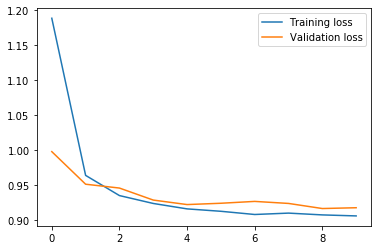

In [ ]:
'''
The file is adapted from the repo https://github.com/chenyaofo/CIFAR-pretrained-models
'''

import torch.nn as nn
import torch.utils.model_zoo as model_zoo
import torch
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.optim as optim
import matplotlib.pyplot as plt
NUM_EPOCH = 10

#GPU call
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride, padding=1, bias=False)


def conv1x1(in_planes, out_planes, stride=1):
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class CifarResNet(nn.Module):

    def __init__(self, block, layers, num_classes=100):
        super(CifarResNet, self).__init__()
        self.inplanes = 16
        self.conv1 = conv3x3(3, 16)
        self.bn1 = nn.BatchNorm2d(16)
        self.relu = nn.ReLU(inplace=True)

        self.layer1 = self._make_layer(block, 16, layers[0])
        self.layer2 = self._make_layer(block, 32, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 64, layers[2], stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(64 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

######################################################
####### Do not modify the code above this line #######
######################################################

class cifar_resnet20(nn.Module):
    def __init__(self):
        super(cifar_resnet20, self).__init__()
        ResNet20 = CifarResNet(BasicBlock, [3, 3, 3])
        url = 'https://github.com/chenyaofo/CIFAR-pretrained-models/releases/download/resnet/cifar100-resnet20-8412cc70.pth'
        ResNet20.load_state_dict(model_zoo.load_url(url))
        modules = list(ResNet20.children())[:-1]
        backbone = nn.Sequential(*modules)
        self.backbone = nn.Sequential(*modules)
        self.fc = nn.Linear(64, 10)

    def forward(self, x):
        out = self.backbone(x)
        out = out.view(out.shape[0], -1)
        return self.fc(out)



if __name__ == '__main__':
    model = cifar_resnet20().to(device)
    transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.2010))])

    trainset = datasets.CIFAR10('./data', train=True, download=True, transform=transform)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True, num_workers=2)

    val_set = datasets.CIFAR10('./data', train=False, download=True, transform=transform)
    val_loader = torch.utils.data.DataLoader(val_set, batch_size=32, shuffle=False, num_workers=2)	

    #classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
 
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(list(model.fc.parameters()), lr=0.001, momentum=0.9)
    ## Do the training
    j = 0
    running_loss_history = []
    val_running_loss_history = []
    mean_train_error_list = []
    mean_val_error_list = []
    temp = 10000
    
    for epoch in range(NUM_EPOCH):  # loop over the dataset multiple times
        running_loss = 0.0
        val_running_loss = 0.0
                
        for t_inputs, t_labels in trainloader :
            t_inputs = t_inputs.to(device)
            t_labels = t_labels.to(device)
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(t_inputs)
            loss = criterion(outputs, t_labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            
        j = j + 1
        print('Epoch %d ends here, and the validation begins' % j)
        
        with torch.no_grad():
          for val_inputs, val_labels in val_loader:
            val_inputs = val_inputs.to(device)
            val_labels = val_labels.to(device)
            val_outputs = model(val_inputs)
            val_loss = criterion(val_outputs, val_labels)
            
            val_running_loss += val_loss.item()
            
        running_loss_history.append(running_loss)
        val_running_loss_history.append(val_running_loss)
        
                
        if val_running_loss < temp:
            print('One more minimaa')
            temp = val_running_loss
            lowest_epoch = epoch + 1
            torch.save(model.state_dict(), './CIFAR_save.pth')

        print('epoch :', (epoch+1))
        print('training loss: {:.4f}'.format(running_loss))
        print('validation loss: {:.4f}'.format(val_running_loss))
    
    for item1 in running_loss_history:
        mean_train_error = item1/len(trainloader)
        mean_train_error_list.append(mean_train_error)
        
    for item2 in val_running_loss_history:    
        mean_val_error = item2/len(val_loader)
        mean_val_error_list.append(mean_val_error)
        
    print('Finally!')
    print('Epoch with lowest validation error = {}'.format(lowest_epoch))
    print('Minimum validation error = {}'.format(temp))
    plt.plot(mean_train_error_list, label = 'Training loss')
    plt.plot(mean_val_error_list, label = 'Validation loss')
    plt.legend()

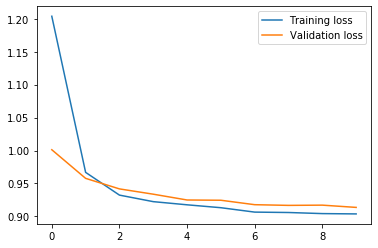

In [ ]:
import matplotlib.pyplot as plt
plt.plot(running_loss_history, label = 'Training loss')
plt.plot(val_running_loss_history, label = 'Validation loss')
plt.legend()

In [ ]:
import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [ ]:
print(mean_train_error)

0.9035383096812096


In [ ]:
print(mean_train_error_list)


[1.1929634596320657, 0.9657634882231363, 0.9331197593163315, 0.9197850554170932, 0.9165296865935822, 0.9123582918523445, 0.9068250586531975, 0.9064329688700056, 0.9034511642584188, 0.9061510921172888]
